In [1]:
!nvidia-smi

Thu Aug 22 13:43:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8               6W /  65W |      8MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../data/proccessed_data/train.csv')
df.head()

,hash,original,hash_type,hash_length
0,b2671f1d87cea55c5db05d1c0a32b073,f7utwbt,md5,32
1,f6478e847928d05d96cf4cbe1a4387eb,dyv3lu1e1iri4r,md5,32
2,b596ad9b6e1fae124ba17f3e28715989,qqpivcprcv,md5,32
3,f6d888e8add4ac2079c8ec2695f9fb1a,a9umb6912v77d,md5,32
4,40010e3eab3216e7d321f661bfd1cb21,fhtkfgpfnqb1x7jhzb,md5,32


## Using machine learning

#### XGBoost

In [4]:
df_xgb = df.copy()

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
label_classes = {}
for col in df_xgb.columns:
    if df_xgb[col].dtype == 'object':
        lb = LabelEncoder()
        df_xgb[col] = lb.fit_transform(df[col].values)
        label_classes[col] = dict(zip(lb.classes_, lb.transform(lb.classes_)))

In [7]:
df_xgb.head()

,hash,original,hash_type,hash_length
0,153206,92900,8,32
1,211653,85386,8,32
2,155965,163373,8,32
3,212129,62803,8,32
4,55112,94632,8,32


In [8]:
X = df_xgb.drop(labels=['hash_type'], axis=1)
y = df_xgb['hash_type']

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((176000, 3), (44000, 3), (176000,), (44000,))

In [12]:
import xgboost as xgb

In [13]:
xgb_model = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    enable_categorical=True
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
xgb_model.score(X_train, y_train), xgb_model.score(X_test, y_test)

(0.4447784090909091, 0.27186363636363636)

In [15]:
y_pred = xgb_model.predict(X_test)
y_pred

array([ 3, 15,  5, ..., 16,  1,  5])

In [16]:
xgb_df = pd.DataFrame({
    'X_hash': X_test['hash'],
    'Actual': y_test,
    'Predicted': y_pred
})
xgb_df.reset_index(inplace=True, drop=True)
xgb_df.head()

,X_hash,Actual,Predicted
0,75573,14,3
1,98247,18,15
2,132298,4,5
3,5387,6,6
4,131829,13,16


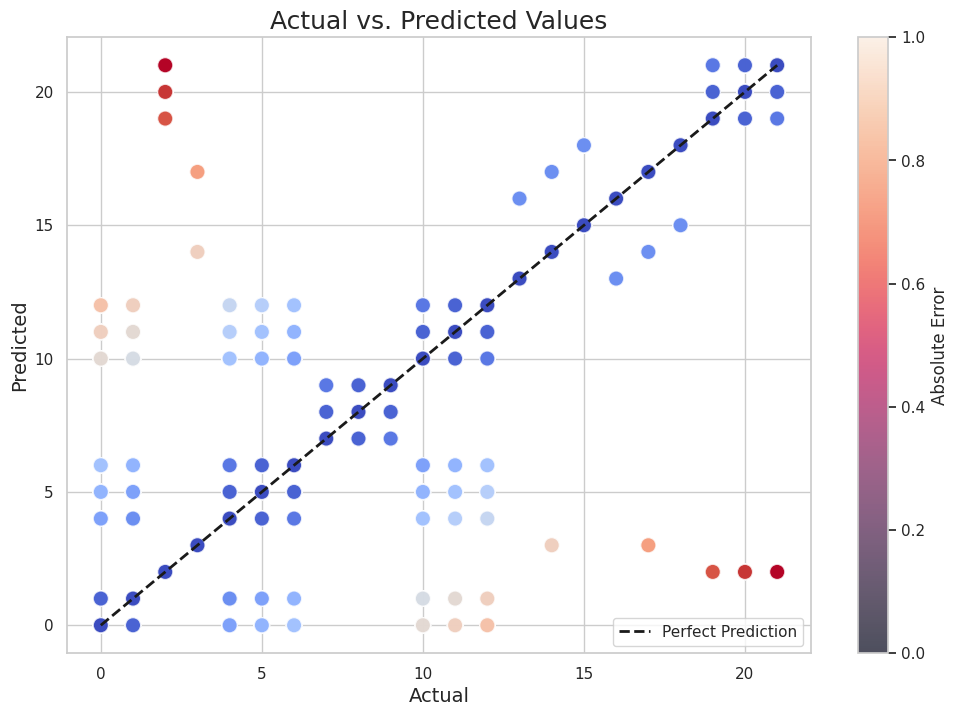

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='Actual', y='Predicted', data=xgb_df, alpha=0.7, edgecolor='w', s=120, hue=np.abs(xgb_df['Actual'] - xgb_df['Predicted']), palette='coolwarm', legend=False)
plt.plot([xgb_df['Actual'].min(), xgb_df['Actual'].max()], [xgb_df['Actual'].min(), xgb_df['Actual'].max()], 'k--', lw=2, label='Perfect Prediction')
plt.colorbar(scatter.collections[0], label='Absolute Error')  # Show color scale
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.title('Actual vs. Predicted Values', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()


In [18]:
inverse_label_classes = {
    'hash': {v: k for k, v in label_classes['hash'].items()},
    'hash_type': {v: k for k, v in label_classes['hash_type'].items()}
}

xgb_df['X_hash'] = xgb_df['X_hash'].map(inverse_label_classes['hash'])
xgb_df['Actual'] = xgb_df['Actual'].map(inverse_label_classes['hash_type'])
xgb_df['Predicted'] = xgb_df['Predicted'].map(inverse_label_classes['hash_type'])

xgb_df.head()

,X_hash,Actual,Predicted
0,57aeae18734765175b7b2bb9ccc306884a2301f17d63e1...,sha256,blake2s
1,727539f41572a5935fa7211cebc015827e155f8b8bcff3...,sha3_384,sha384
2,9a54bed246abd320193191de2f9bf3ec9a83eef3,dsaEncryption,dsaWithSHA
3,0623b4c7aa70e1cf59d43274a355eebba512ac5c,ecdsa-with-SHA1,ecdsa-with-SHA1
4,99ca2a25b877cee137194b7291fb22e84d1f16e5e77617...,sha224,sha3_224


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

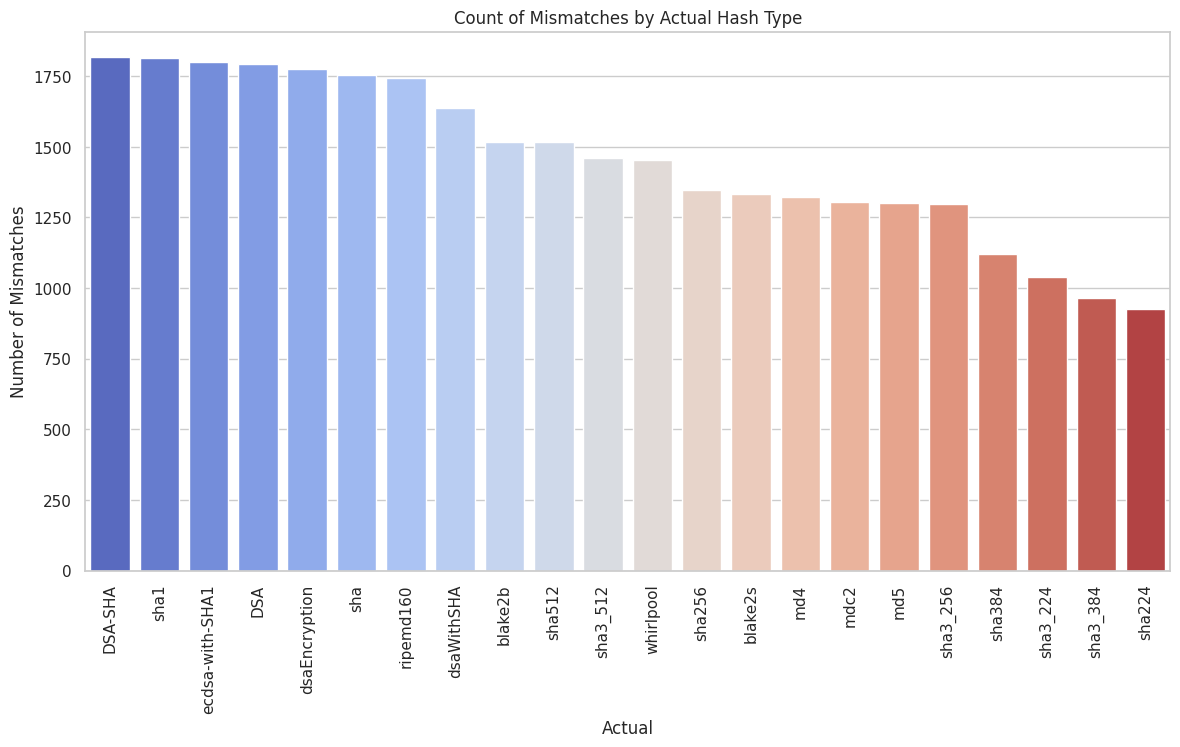

In [20]:
mismatches = xgb_df[xgb_df['Actual'] != xgb_df['Predicted']]
mismatch_counts = mismatches['Actual'].value_counts()

plt.figure(figsize=(14, 7))
sns.barplot(x=mismatch_counts.index, y=mismatch_counts.values, palette='coolwarm')
plt.title('Count of Mismatches by Actual Hash Type')
plt.xticks(rotation=90)
plt.ylabel('Number of Mismatches')
plt.show()


### LightBGM

In [21]:
import lightgbm as lgb

In [22]:
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 176000, number of used features: 3
[LightGBM] [Info] Start training from score -3.095302
[LightGBM] [Info] Start training from score -3.099831
[LightGBM] [Info] Start training from score -3.086304
[LightGBM] [Info] Start training from score -3.090168
[LightGBM] [Info] Start training from score -3.094172
[LightGBM] [Info] Start training from score -3.078867
[LightGBM] [Info] Start training from score -3.095050
[LightGBM] [Info] Start training from score -3.087299
[LightGBM] [Info] Start training from score -3.087424
[LightGBM] [Info] Start training from score -3.090668
[LightGBM] [Info] Start training from score -3.090543
[LightGBM] [Info] Start training from score -3.093546


LGBMClassifier()

In [23]:
lgb_model.score(X_train, y_train), lgb_model.score(X_test, y_test)

(0.4464090909090909, 0.2707727272727273)

#### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [29]:
X = df_xgb.drop(labels=['hash_type'], axis=1)
y = df_xgb['hash_type']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [31]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
rf_model.score(X_train, y_train), rf_model.score(X_test, y_test)

(0.9999943181818182, 0.2760681818181818)

## Using deep learning